In [4]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tools.ObjectDetector import Detector

## Object Detection

In [5]:
image_path = '13A.jpg'

In [6]:
detector = Detector('../runs/detect/train3/weights/best.pt')
result = detector.inference(image_path)
box_dict = detector.get_all_boxes(result)


0: 640x480 1 grape_cluster, 1 index, 1 measure_label, 206.9ms
Speed: 5.0ms preprocess, 206.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


In [7]:
box_dict

{'grape_cluster': array([     742.42,      86.956,        1709,        1533], dtype=float32),
 'index': array([     1949.2,      336.48,      2757.2,       565.7], dtype=float32),
 'measure_label': array([     464.56,      154.08,      761.47,      1425.8], dtype=float32)}

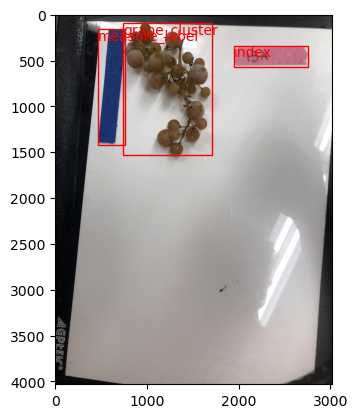

<Figure size 4000x4000 with 0 Axes>

In [8]:
detector.plt_all_boxes(image_path, box_dict)

# Visualization Tools

In [9]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_anns(anns):
    if len(anns) == 0:
        return

    # Convert the tensors to numpy arrays and sort them
    np_anns = [ann.numpy() for ann in anns]
    sorted_anns = sorted(np_anns, key=lambda x: np.sum(x), reverse=True)

    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Initialize an image with transparency
    img = np.ones((sorted_anns[0].shape[0], sorted_anns[0].shape[1], 4))
    img[:, :, 3] = 0
    
    i = 0
    for ann in sorted_anns:
        # Create a random color mask with transparency
        color_mask = np.concatenate([np.random.random(3), [0.35]])

        # Apply the mask to the annotation areas
        img[ann.astype(bool)] = color_mask
        
        # add text
        text = str(i)
        ys, xs = np.where(ann)
        centroid = (np.mean(xs), np.mean(ys))
        ax.scatter(centroid[0], centroid[1], color='green', marker='.', s=50, edgecolor='white', linewidth=1.25)    
        # ax.text(centroid[0], centroid[1], text, color='white', ha='center', va='center')
        # i += 1
        
    ax.imshow(img)

# Segmentation

In [10]:
from tools.Segmentator import Segmentator
import numpy as np
import torch

In [11]:
import cv2

image = cv2.imread('13A.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [12]:
box_dict['grape_cluster']

array([     742.42,      86.956,        1709,        1533], dtype=float32)

In [13]:
grape_bbox = box_dict['grape_cluster']
index_bbox = [     1945.9,      343.54,        2761,      570.16]
measure_bbox = [     465.99,      156.97,      741.25,      1424.4]

In [14]:
GrapeSegmenter = Segmentator(model_path='./FastSAM/weights/FastSAM-x.pt', DEVICE='cpu')
prompt_process= GrapeSegmenter.start(image_path)


image 1/1 E:\Dev\GrapeYOLO\13A.jpg: 1024x768 50 objects, 2200.8ms
Speed: 9.5ms preprocess, 2200.8ms inference, 2604.7ms postprocess per image at shape (1, 3, 1024, 1024)


In [15]:
ann_everything = GrapeSegmenter.seg_everything(prompt_process)
len(ann_everything)

50

In [16]:
grape_ann = GrapeSegmenter.filter_within_bbox(ann_everything, grape_bbox)
len(grape_ann)

34

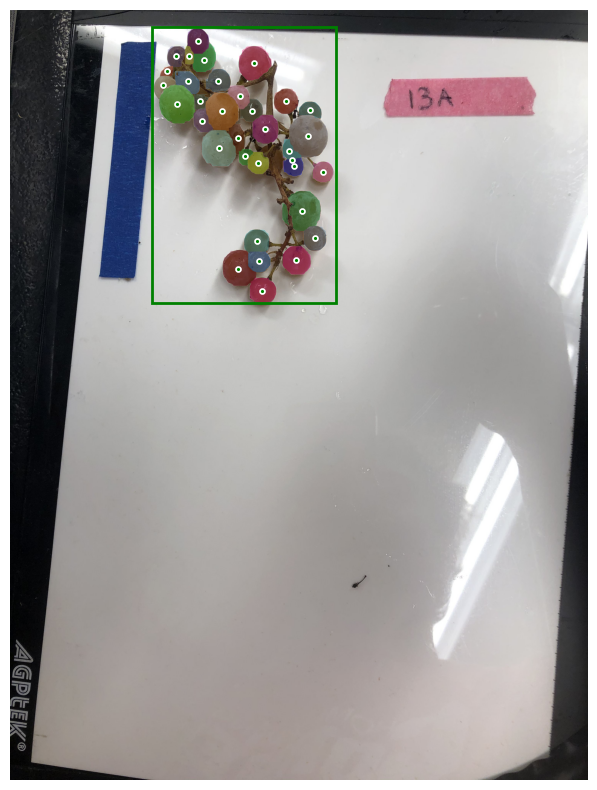

'\nberry per length\ncircle marker major minor axis\n\n\nwhere the cluster\ncompactness\ndisease prediction model\n'

In [17]:
input_box = np.array(grape_bbox)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(grape_ann)
show_box(input_box, plt.gca())
plt.axis('off')
plt.show() 

'''
berry per length
circle marker major minor axis


where the cluster
compactness
disease prediction model
'''

## Segment measure label

In [25]:
measure_ann = GrapeSegmenter.seg_with_bbox(prompt_process, measure_bbox)
len(measure_ann)

1

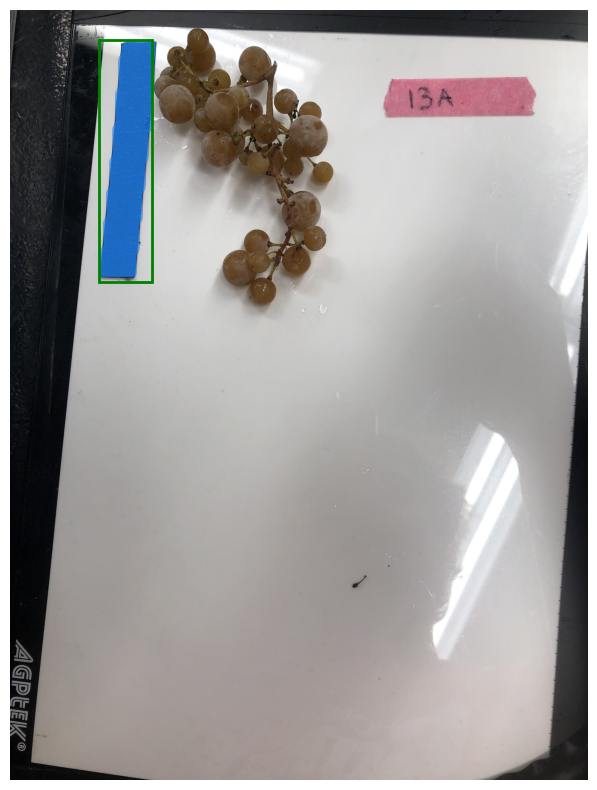

In [26]:
input_box = np.array(measure_bbox)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(measure_ann, plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show() 

## Segment Index

In [27]:
index_ann = GrapeSegmenter.seg_with_bbox(prompt_process, index_bbox)
len(index_ann)

1

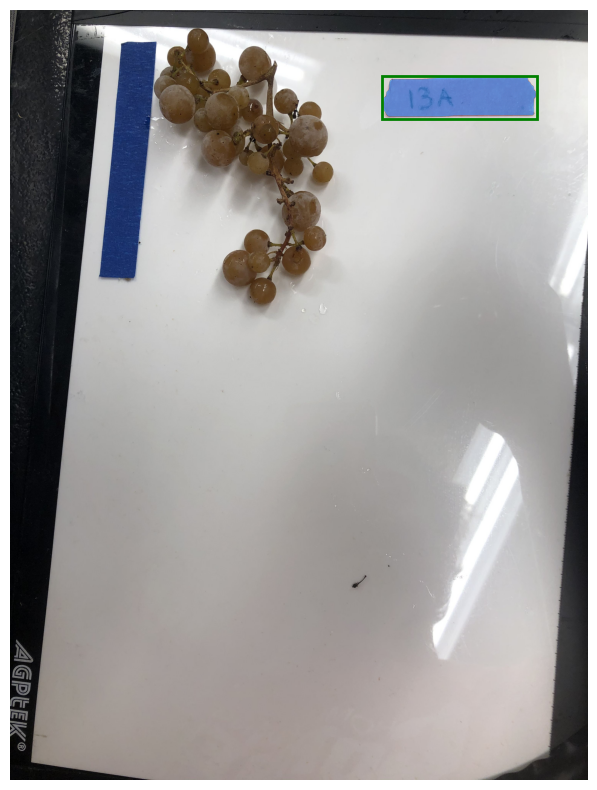

In [28]:
input_box = np.array(index_bbox)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(index_ann, plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show() 